# ASO Data Extraction

Tony Cannistra | Feb 2018

---
We'll try to use information from the ASO to train the models. Not 100% sure how to do this. 

Here's an idea for a workflow: 

1. **Download** ASO snow cover raster. 
2. **Extract** mask from raster where there's a large enough snow depth to likely have a signal (*what's the threshold?*)
3. **Search and Download** pixels from Planet from mask. 
4. **Train model** using all pixels from masked image (they all contain snow?)

In this notebook we'll just 

In [1]:
import requests
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import shapes
from rasterio.plot import show
from rasterio.mask import geometry_mask, mask
from shapely.geometry import mapping, shape, Polygon, Point
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import timedelta
from xml.dom import minidom
from skimage import img_as_ubyte
from skimage.exposure import equalize_adapthist as _hist
import seaborn as sns
import gc

import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = (27, 9)
plt.rcParams['font.size'] = 12

## 1 + 2: Check out ASO Raster + Get Mask

In [2]:
YEAR = 2017

In [3]:
asodb = "../data/aso-urls.csv"

asourls = pd.read_csv(asodb, parse_dates=[0]).set_index('date')
image = asourls[asourls.index.year == YEAR].iloc[1]
asoImage = rio.open(image.url)
image_crs = ccrs.epsg(asoImage.crs['init'].split(":")[1])


In [4]:
asoData = asoImage.read(1).astype('float32')

In [5]:
asoData[asoData == -9999] = 0

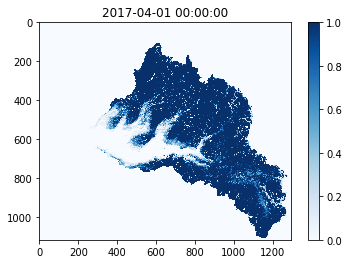

In [6]:
plt.imshow(asoData.astype('float32'), cmap="Blues", vmax=1, vmin=0)
plt.title(image.name)
plt.colorbar()


In [7]:
geoms = [shape(s[0]) for s in shapes((asoData > 0).astype('int16'), transform=asoImage.transform)]
geoms = gpd.GeoDataFrame(geometry=geoms)
geoms.geometry = geoms.geometry.buffer(0) # self-intersection issues
geoms.crs = asoImage.crs
geoms['id'] = geoms.index
geoms['area'] = geoms.geometry.area
geoms = geoms.sort_values('area', ascending=False)
geoms = geoms.to_crs(ccrs.PlateCarree().proj4_init)
bounds = geoms.cascaded_union.bounds

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/rasterio/features.py:102: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [8]:
bounds

(-119.93913483662395,
 37.72123320943646,
 -119.18390169064847,
 38.24106049943262)

location 1 for snow on, location 0 for snow off

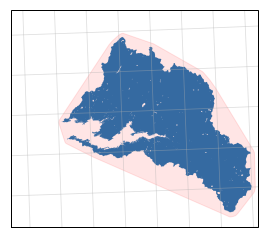

In [9]:
thisgeom = geoms.iloc[1].geometry
ax = plt.axes(projection=ccrs.UTM(10))
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_geometries([thisgeom.buffer(0)], crs=ccrs.PlateCarree())
chull = thisgeom.convex_hull
ax.add_geometries([chull.buffer(0.01)], color='red', crs=ccrs.PlateCarree(), alpha=0.1)
ax.gridlines( alpha=0.4)


## 2: Search Planet API for Imagery 
Let's see if AOI is too pointy

In [10]:
from image_utils.search import Search

convex hull for snow off, regular for snow on

In [11]:
geomidx = geoms.iloc[1].name
locgdf = geoms[geoms.index == geomidx]
locgdf['geometry'] = locgdf.geometry
start_date = image.name 
end_date = start_date + timedelta(days=5)
datedf = pd.DataFrame([pd.Series({
    'id' : geomidx, 
    'start_date' : start_date, 
    'end_date' : end_date})])

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
s = Search(locgdf, datedf)
results = s.query()
results = gpd.GeoDataFrame(results, geometry=[shape(s) for s in results.geometry])
results['overlaparea'] = results[results.intersects(thisgeom)].intersection(thisgeom).area
satframes = results.geometry

Querying Planet API: 100%|██████████| 1/1 [00:10<00:00, 10.59s/searches]


Text(0.5,1,'2017-04-01 00:00:00-2017-04-06 00:00:00')

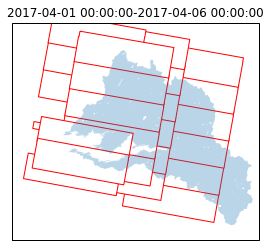

In [16]:
ax = plt.axes(projection=ccrs.UTM(10))
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent)
ax.add_geometries(satframes, crs=ccrs.PlateCarree(), facecolor='white', edgecolor='Red')
ax.add_geometries([thisgeom], crs=ccrs.PlateCarree(), alpha=0.3)
ax.set_title("{!s}-{!s}".format(start_date, end_date))

chosen overlap = 0(?) for snow off and 20 for snow on 

Text(0.5,1,'2017-04-01 00:00:00-2017-04-06 00:00:00')

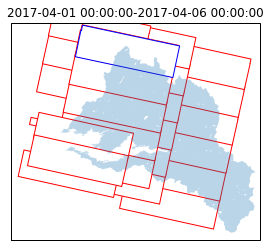

In [37]:
min_overlap = 0.00050 # degrees??
chosen_overlap = 19
overlaps = results[results.overlaps(thisgeom)]
bigoverlaps = results[results['overlaparea'] > min_overlap]
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent)
ax.add_geometries(overlaps.geometry, crs=ccrs.PlateCarree(), facecolor='white', edgecolor='Red')
ax.add_geometries([bigoverlaps.iloc[chosen_overlap].geometry], crs=ccrs.PlateCarree(), facecolor='white', edgecolor='blue')
ax.add_geometries([thisgeom], crs=ccrs.PlateCarree(), alpha=0.3)
ax.set_title("{!s}-{!s}".format(start_date, end_date))

In [50]:
chosenOverlap = bigoverlaps.iloc[chosen_overlap]
intersection = thisgeom.intersection(chosenOverlap.geometry)

20170404_180056_0e19


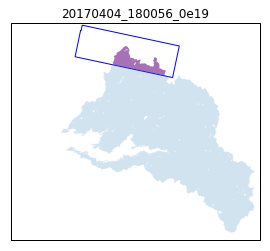

In [58]:
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
ax.set_extent(extent)
ax.add_geometries([chosenOverlap.geometry], crs=ccrs.PlateCarree(), facecolor='white', edgecolor='blue')
ax.add_geometries([thisgeom], crs=ccrs.PlateCarree(), alpha=0.2)
ax.add_geometries([intersection], crs=ccrs.PlateCarree(), alpha=0.5, facecolor='purple')
ax.set_title(chosenOverlap.id)
print(chosenOverlap.id)

In [59]:
results[results.id == chosenOverlap.id].properties.values[0]['cloud_cover']

0.01

In [60]:
chosenOverlap.id

'20170404_180056_0e19'

### Download Image from Planet

In [61]:
from imp import reload
from image_utils import download
reload(download)
CroppedDownload = download.CroppedDownload

In [62]:
d = download.WholeDownload(0, [chosenOverlap.id], "../images/ASO")


In [63]:
files = d.run()

Starting activation for image 20170404_180056_0e19
querying assets at https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_180056_0e19/assets/
fetching assets...status:200
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_180056_0e19/assets/
state: activating
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_180056_0e19/assets/
state: activating
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_180056_0e19/assets/
state: activating
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_180056_0e19/assets/
state: activating
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_180056_0e19/assets/
state: activating
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_180056_0e19/assets/
state: activating
Checking url https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170404_18

In [22]:
print(files)

[('../images/ASO/0_20160620_191028_0c79.tif', '../images/ASO/0_20160620_191028_0c79.xml')]


## View Image

In [23]:
def openImage(imagef, coeffs=True):   
    image = rio.open(imagef)
    if not coeffs: return(image)
    
    path, base = os.path.split(imagef)
    root = base.split(".")[0]
    meta = minidom.parse(open(os.path.join(path, root + ".xml")))
    nodes = meta.getElementsByTagName("ps:bandSpecificMetadata")

    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    
    return((image, coeffs))

In [24]:
#files = [('../images/ASO/0_20170401_175413_1024.tif', '../images/ASO/0_20170401_175413_1024.xml')]
imagedir, imagefile = os.path.split(files[0][0])
imageid = imagefile.split(".")[0]

In [25]:
image, coefs = openImage(files[0][0])

b1_toa = image.read(1) * coefs[1]
b2_toa = image.read(2) * coefs[2]
b3_toa = image.read(3) * coefs[3]

stack = np.stack([b3_toa, b2_toa, b1_toa], axis=2)



In [26]:
import pyproj
from functools import partial
from shapely.ops import transform

project_fun = partial(pyproj.transform, 
                      pyproj.Proj(init="epsg:%s" % 32662), 
                      pyproj.Proj(init=image.crs['init']))

geom = transform(project_fun, thisgeom)


In [27]:
x, y = zip(*list(thisgeom.exterior.coords))

imgcrs = ccrs.epsg(image.crs['init'].split(":")[1])
transformed = imgcrs.transform_points(ccrs.PlateCarree(), np.array(x), np.array(y))[:, :2]

big  = Polygon(shell=zip(transformed[:, 0], transformed[:, 1]))

In [28]:
m, transform = mask(image, [mapping(big)], crop=True)



In [29]:
data = m.data

In [30]:
data = data.transpose((1, 2, 0))
data.shape

(3280, 5952, 4)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


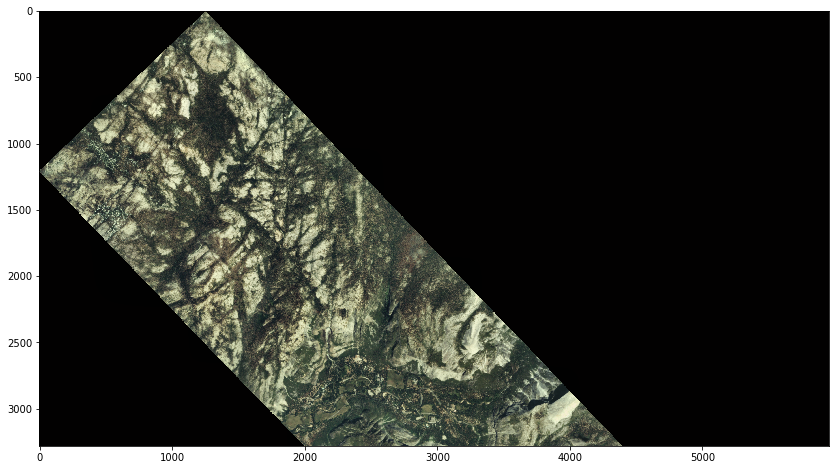

In [38]:
plt.figure(figsize=(20,8))

plt.imshow(img_as_ubyte(np.stack([_hist(data[:,:,2]), _hist(data[:,:,1]), _hist(data[:,:,0])], axis=2)))

plt.savefig(os.path.join(imagedir, "{}_cropped.png".format(imageid)), dpi=200, bbox='tight')

In [35]:
b1 = pd.DataFrame(m[0, :, :].ravel(), columns=["band1"])
b2 = pd.DataFrame(m[1, :, :].ravel(), columns=["band2"])
b3 = pd.DataFrame(m[2, :, :].ravel(), columns=["band3"])
b4 = pd.DataFrame(m[3, :, :].ravel(), columns=["band4"])
a = pd.concat([b1, b2, b3, b4], axis=1)
a = a[(a.T != 0).any()]

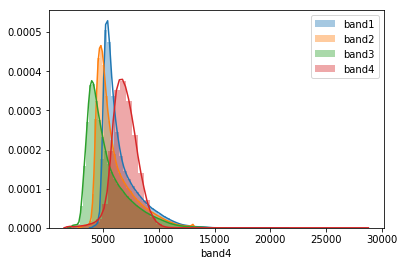

In [37]:
_ = [sns.distplot(a[c], label=c) for c in a.columns]
plt.legend()
plt.savefig(os.path.join(imagedir,"{}_hist.png".format(imageid)))

In [38]:
?plt.savefig

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, dpi=None, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=None)

The output formats available depend on the backend being used.

Parameters
----------

fname : str or file-like object
    A string containing a path to a filename, or a Python
    file-like object, or possibly some backend-dependent object
    such as :class:`~matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is *None* and *fname* is a string, the output
    format is deduced from the extension of the filename. If
    the filename has no extension, the value of the rc parameter
    ``savefig.format`` is used.

    If *fname* is not a string, remember to specify *format* to
    ensure that the correct backend is used.

Other Parameters
----------------

dpi : [ *None* | scalar >

In [36]:
dirname, filename = os.path.split(files[0][0])
pklname = os.path.join(dirname,filename.split(".")[0] + "_cropped.pkl")
a.to_pickle(pklname)

In [ ]:
def write_cropped_image(image_, transform, src_meta, outname = "cropped.tif"):
    print(image_.shape)
    height = image_.shape[0] 
    width = image_.shape[1]
    meta = src_meta.copy()
    meta.update(dtype=rio.uint8, 
                height=int(height), width=int(width), 
                nodata=src_meta['nodata'], transform=transform, compress='lzw')
    with rio.open(outname, 'w', **meta) as dst:
        dst.write(img_as_ubyte(image_).transpose((2, 0, 1)))


In [ ]:
path, filename = os.path.split(files[0][0])
filename = filename.split(".")[0] + "_cropped.tif"
cropped_outfile = os.path.join(path, filename)
write_cropped_image(data, transform, image.profile, cropped_outfile)